# Hybrid Retriever + Reranker

Комбинируем BM25 и Dense Retriever, добавляем переранжирование.

In [1]:
!pip install pyarrow==18.1.0 -q
!pip install datasets==2.14.0 sentence-transformers sentencepiece faiss-cpu rank-bm25 torch tqdm -q
!pip install huggingface_hub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 46.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.2 requires pyarrow>=21.0.0, but you have pyarrow 18.1.0 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 78.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resol

In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import gzip
import gdown
import random
import requests
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
from huggingface_hub import hf_hub_download, list_repo_files
import sentencepiece as spm
from sentence_transformers import SentenceTransformer, CrossEncoder
from rank_bm25 import BM25Okapi
import faiss
import gc
import time

random.seed(42)
np.random.seed(42)

print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

CUDA: True
GPU: Tesla T4


## 1. Загрузка данных

In [3]:
BASE_URL = "https://huggingface.co/datasets/miracl/miracl/resolve/main/miracl-v1.0-ru/"

def load_queries(split: str) -> dict:
    url = f"{BASE_URL}topics/topics.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        queries = {}
        for line in response.text.strip().split('\n')[1:]:
            parts = line.split('\t')
            if len(parts) >= 2:
                queries[parts[0]] = parts[1]
        return queries
    except:
        return {}

def load_qrels(split: str) -> dict:
    url = f"{BASE_URL}qrels/qrels.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        qrels = defaultdict(lambda: {'positive': [], 'negative': []})
        for line in response.text.strip().split('\n'):
            parts = line.split('\t')
            if len(parts) >= 4:
                qid, doc_id, rel = parts[0], parts[2], int(parts[3])
                key = 'positive' if rel > 0 else 'negative'
                qrels[qid][key].append(doc_id)
        return dict(qrels)
    except:
        return {}

def get_required_doc_ids(qrels_dict: dict) -> set:
    doc_ids = set()
    for q in qrels_dict.values():
        doc_ids.update(q.get('positive', []))
        doc_ids.update(q.get('negative', []))
    return doc_ids

In [4]:
dev_queries = load_queries('dev')
dev_qrels = load_qrels('dev')
train_queries = load_queries('train')
train_qrels = load_qrels('train')

all_qrels = {**dev_qrels, **train_qrels}
required_doc_ids = get_required_doc_ids(all_qrels)

print(f"Dev: {len(dev_queries)} запросов")
print(f"Train: {len(train_queries)} запросов")

Dev: 1251 запросов
Train: 4682 запросов


In [5]:
def load_corpus(target_docs: int = 500_000, seed: int = 42) -> tuple:
    random.seed(seed)
    
    all_files = list_repo_files("miracl/miracl-corpus", repo_type="dataset")
    jsonl_files = sorted([f for f in all_files if 'ru' in f and f.endswith('.jsonl.gz')])
    docs_per_file = target_docs // len(jsonl_files)

    corpus = {}
    doc_ids = []
    passages = []

    for jsonl_file in tqdm(jsonl_files, desc="Загрузка корпуса"):
        try:
            file_path = hf_hub_download(
                repo_id="miracl/miracl-corpus",
                filename=jsonl_file,
                repo_type="dataset"
            )

            file_docs = []
            required_docs = []

            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                for line in f:
                    if not line.strip():
                        continue
                    item = json.loads(line)
                    doc = {
                        'docid': item['docid'],
                        'title': item['title'],
                        'text': item['text'],
                        'full_text': f"{item['title']}. {item['text']}"
                    }
                    
                    if item['docid'] in required_doc_ids:
                        required_docs.append(doc)
                    else:
                        file_docs.append(doc)

            sample_size = min(docs_per_file, len(file_docs))
            selected = random.sample(file_docs, sample_size) if file_docs else []
            
            for doc in selected + required_docs:
                if doc['docid'] not in corpus:
                    corpus[doc['docid']] = {
                        'title': doc['title'],
                        'text': doc['text'],
                        'full_text': doc['full_text']
                    }
                    doc_ids.append(doc['docid'])
                    passages.append(doc['full_text'])

        except Exception as e:
            print(f"Ошибка: {e}")

    return corpus, doc_ids, passages

corpus, doc_ids, passages = load_corpus(target_docs=500_000)
print(f"Загружено документов: {len(corpus):,}")

Загрузка корпуса:   0%|          | 0/20 [00:00<?, ?it/s]

miracl-corpus-v1.0-ru/docs-0.jsonl.gz:   0%|          | 0.00/100M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-1.jsonl.gz:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-10.jsonl.gz:   0%|          | 0.00/75.7M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-11.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-12.jsonl.gz:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-13.jsonl.gz:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-14.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-15.jsonl.gz:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-16.jsonl.gz:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-17.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-18.jsonl.gz:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-19.jsonl.gz:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-2.jsonl.gz:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-3.jsonl.gz:   0%|          | 0.00/89.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-4.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-5.jsonl.gz:   0%|          | 0.00/88.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-6.jsonl.gz:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-7.jsonl.gz:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-8.jsonl.gz:   0%|          | 0.00/74.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-9.jsonl.gz:   0%|          | 0.00/73.5M [00:00<?, ?B/s]

Загружено документов: 541,007


## 2. BM25 с BPE токенизацией

In [6]:
BPE_MODEL_PATH = "/kaggle/input/bm25data/bpe_ru_25k.model"

class BM25_BPE:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.bm25 = None
        self.doc_ids = None
        self.passages = None
        self.min_token_len = 2

    def tokenize(self, text: str) -> list:
        tokens = self.sp.encode_as_pieces(text)
        filtered = []
        for token in tokens:
            clean_token = token.replace("▁", "")
            if len(clean_token) < self.min_token_len:
                continue
            if clean_token in '.,!?;:—–-()[]{}«»"\'':
                continue
            filtered.append(token)
        return filtered

    def fit(self, doc_ids: list, passages: list):
        self.doc_ids = doc_ids
        self.passages = passages
        
        tokenized_corpus = [self.tokenize(p) for p in tqdm(passages, desc="Токенизация")]
        self.bm25 = BM25Okapi(tokenized_corpus)
        
        del tokenized_corpus
        gc.collect()
        print(f"BM25 индекс: {len(doc_ids):,} документов")

    def search(self, query: str, top_k: int = 10) -> list:
        query_tokens = self.tokenize(query)
        scores = self.bm25.get_scores(query_tokens)
        top_indices = np.argsort(scores)[::-1][:top_k]
        
        return [{
            'doc_id': self.doc_ids[idx],
            'score': float(scores[idx]),
            'passage': self.passages[idx]
        } for idx in top_indices]

In [7]:
bm25_bpe = BM25_BPE(BPE_MODEL_PATH)
bm25_bpe.fit(doc_ids, passages)

Токенизация:   0%|          | 0/541007 [00:00<?, ?it/s]

BM25 индекс: 541,007 документов


## 3. Dense Retriever (E5)

In [10]:
# Скачивание FAISS индекса с Google Drive

file_id = "1_z6Kup484-UKe4UxTTKRN2fzPmtYLsKn"
url = f"https://drive.google.com/uc?id={file_id}&export=download"
output = "dense_e5.faiss"

gdown.download(url, output, quiet=False)
print(f"Индекс скачан: {output}")

Downloading...
From (original): https://drive.google.com/uc?id=1_z6Kup484-UKe4UxTTKRN2fzPmtYLsKn&export=download
From (redirected): https://drive.google.com/uc?id=1_z6Kup484-UKe4UxTTKRN2fzPmtYLsKn&export=download&confirm=t&uuid=da44e3cc-ab62-44e9-9308-df042894bcd5
To: /kaggle/working/dense_e5.faiss
100%|██████████| 1.66G/1.66G [00:11<00:00, 141MB/s] 

Индекс скачан: dense_e5.faiss


In [11]:
MODEL_NAME = "intfloat/multilingual-e5-base"
DENSE_INDEX_PATH = "dense_e5.faiss"

class DenseRetrieverE5:
    def __init__(self, model_name: str):
        self.model = SentenceTransformer(model_name)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        if self.device == 'cuda':
            self.model = self.model.to('cuda')
            self.model.half()
        
        self.index = None
        self.doc_ids = None
        self.passages = None
        self.dimension = None
    
    def _prepare_passage(self, text: str) -> str:
        return f"passage: {text}"
    
    def _prepare_query(self, text: str) -> str:
        return f"query: {text}"
    
    def search(self, query: str, top_k: int = 10) -> list:
        prepared_query = self._prepare_query(query)
        
        with torch.no_grad():
            query_emb = self.model.encode(
                [prepared_query],
                convert_to_numpy=True,
                normalize_embeddings=True
            ).astype('float32')
        
        scores, indices = self.index.search(query_emb, top_k)
        
        return [{
            'doc_id': self.doc_ids[idx],
            'score': float(score),
            'passage': self.passages[idx]
        } for idx, score in zip(indices[0], scores[0])]

In [12]:
# Загрузка сохранённого индекса
dense_retriever = DenseRetrieverE5(MODEL_NAME)
dense_retriever.index = faiss.read_index(DENSE_INDEX_PATH)
dense_retriever.doc_ids = doc_ids
dense_retriever.passages = passages
dense_retriever.dimension = dense_retriever.index.d

print(f"Dense индекс загружен: {dense_retriever.index.ntotal:,} документов")

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Dense индекс загружен: 541,007 документов


## 4. Hybrid Retriever

In [13]:
class HybridRetriever:
    def __init__(self, bm25_retriever, dense_retriever, alpha: float = 0.5):
        self.bm25 = bm25_retriever
        self.dense = dense_retriever
        self.alpha = alpha
        self.doc_ids = dense_retriever.doc_ids
        self.passages = dense_retriever.passages
    
    def search(self, query: str, top_k: int = 10, candidates: int = 100) -> list:
        bm25_results = self.bm25.search(query, top_k=candidates)
        dense_results = self.dense.search(query, top_k=candidates)
        
        # Нормализация BM25
        bm25_scores = [r['score'] for r in bm25_results]
        min_b, max_b = min(bm25_scores), max(bm25_scores)
        range_b = max_b - min_b + 1e-6
        
        all_docs = {}
        
        for r in bm25_results:
            norm_score = (r['score'] - min_b) / range_b
            all_docs[r['doc_id']] = {'bm25': norm_score, 'dense': 0.0, 'passage': r['passage']}
        
        for r in dense_results:
            if r['doc_id'] in all_docs:
                all_docs[r['doc_id']]['dense'] = r['score']
            else:
                all_docs[r['doc_id']] = {'bm25': 0.0, 'dense': r['score'], 'passage': r['passage']}
        
        results = []
        for doc_id, data in all_docs.items():
            combined = (1 - self.alpha) * data['bm25'] + self.alpha * data['dense']
            results.append({'doc_id': doc_id, 'score': combined, 'passage': data['passage']})
        
        results.sort(key=lambda x: x['score'], reverse=True)
        return results[:top_k]

## 5. Подбор оптимального alpha

In [14]:
def evaluate(retriever, queries: dict, qrels: dict, ks: list = [1, 5, 10, 20, 100]) -> dict:
    metrics = defaultdict(list)
    indexed = set(retriever.doc_ids)
    
    for qid, text in tqdm(queries.items(), desc="Оценка"):
        if qid not in qrels:
            continue
        
        relevant = [d for d in qrels[qid]['positive'] if d in indexed]
        if not relevant:
            continue
        
        results = retriever.search(text, top_k=max(ks))
        retrieved = [r['doc_id'] for r in results]
        
        for k in ks:
            hit = len(set(retrieved[:k]) & set(relevant))
            metrics[f'Recall@{k}'].append(hit / len(relevant))
        
        for rank, doc_id in enumerate(retrieved, 1):
            if doc_id in set(relevant):
                metrics['MRR'].append(1.0 / rank)
                break
        else:
            metrics['MRR'].append(0.0)
        
        dcg = sum(1.0/np.log2(i+2) for i, d in enumerate(retrieved[:10]) if d in set(relevant))
        idcg = sum(1.0/np.log2(i+2) for i in range(min(10, len(relevant))))
        metrics['NDCG@10'].append(dcg / idcg if idcg > 0 else 0)
    
    return {k: np.mean(v) for k, v in metrics.items()}

In [15]:
# Предподсчёт скоров для быстрого подбора alpha
dev_sample = dict(list(dev_queries.items())[:400])
CANDIDATES = 100

precomputed = {}
for qid, query_text in tqdm(dev_sample.items(), desc="Предподсчёт"):
    bm25_results = bm25_bpe.search(query_text, top_k=CANDIDATES)
    dense_results = dense_retriever.search(query_text, top_k=CANDIDATES)
    
    bm25_scores = [r['score'] for r in bm25_results]
    min_b, max_b = min(bm25_scores), max(bm25_scores)
    range_b = max_b - min_b + 1e-6
    
    doc_scores = {}
    for r in bm25_results:
        norm_score = (r['score'] - min_b) / range_b
        doc_scores[r['doc_id']] = {'bm25': norm_score, 'dense': 0.0, 'passage': r['passage']}
    
    for r in dense_results:
        if r['doc_id'] in doc_scores:
            doc_scores[r['doc_id']]['dense'] = r['score']
        else:
            doc_scores[r['doc_id']] = {'bm25': 0.0, 'dense': r['score'], 'passage': r['passage']}
    
    precomputed[qid] = doc_scores

Предподсчёт:   0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
def evaluate_alpha(alpha: float, precomputed: dict, qrels: dict, k: int = 10) -> dict:
    mrr_list, recall_list, ndcg_list = [], [], []
    indexed = set(doc_ids)
    
    for qid, doc_scores in precomputed.items():
        if qid not in qrels:
            continue
        
        relevant = [d for d in qrels[qid]['positive'] if d in indexed]
        if not relevant:
            continue
        
        combined = [(doc_id, (1-alpha)*s['bm25'] + alpha*s['dense']) 
                    for doc_id, s in doc_scores.items()]
        combined.sort(key=lambda x: x[1], reverse=True)
        retrieved = [doc_id for doc_id, _ in combined[:k]]
        
        mrr = 0.0
        for rank, doc_id in enumerate(retrieved, 1):
            if doc_id in set(relevant):
                mrr = 1.0 / rank
                break
        mrr_list.append(mrr)
        
        hit = len(set(retrieved) & set(relevant))
        recall_list.append(hit / len(relevant))
        
        dcg = sum(1.0/np.log2(i+2) for i, d in enumerate(retrieved[:10]) if d in set(relevant))
        idcg = sum(1.0/np.log2(i+2) for i in range(min(10, len(relevant))))
        ndcg_list.append(dcg / idcg if idcg > 0 else 0)
    
    return {'MRR': np.mean(mrr_list), 'Recall@10': np.mean(recall_list), 'NDCG@10': np.mean(ndcg_list)}

# Подбор alpha
alphas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_results = []

for alpha in alphas:
    metrics = evaluate_alpha(alpha, precomputed, dev_qrels)
    alpha_results.append({'alpha': alpha, **metrics})
    print(f"α={alpha:.1f}: MRR={metrics['MRR']:.4f}")

best_result = max(alpha_results, key=lambda x: x['MRR'])
BEST_ALPHA = best_result['alpha']
print(f"\nЛучший alpha: {BEST_ALPHA}")

α=0.0: MRR=0.4169
α=0.2: MRR=0.4544
α=0.4: MRR=0.4994
α=0.5: MRR=0.5175
α=0.6: MRR=0.5339
α=0.7: MRR=0.5578
α=0.8: MRR=0.5910
α=0.9: MRR=0.6769
α=1.0: MRR=0.8035

Лучший alpha: 1.0


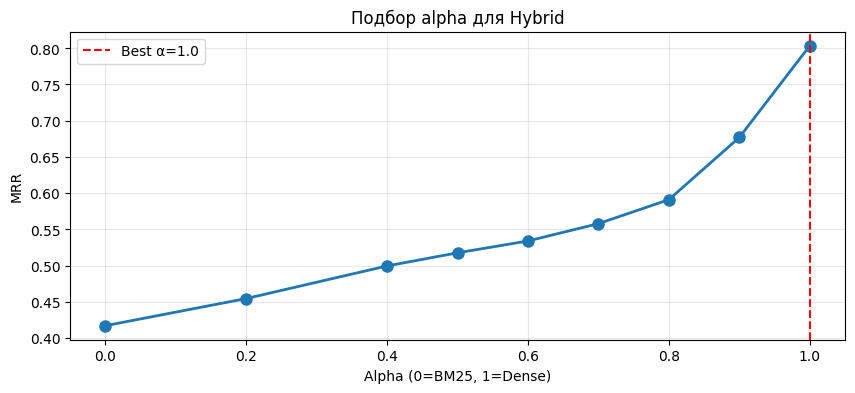

In [17]:
plt.figure(figsize=(10, 4))

alphas_plot = [r['alpha'] for r in alpha_results]
mrr_plot = [r['MRR'] for r in alpha_results]

plt.plot(alphas_plot, mrr_plot, 'o-', linewidth=2, markersize=8)
plt.axvline(x=BEST_ALPHA, color='red', linestyle='--', label=f'Best α={BEST_ALPHA}')
plt.xlabel('Alpha (0=BM25, 1=Dense)')
plt.ylabel('MRR')
plt.title('Подбор alpha для Hybrid')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('hybrid_alpha.png', dpi=150)
plt.show()

In [18]:
hybrid_retriever = HybridRetriever(bm25_bpe, dense_retriever, alpha=BEST_ALPHA)
print(f"Hybrid создан: {(1-BEST_ALPHA)*100:.0f}% BM25 + {BEST_ALPHA*100:.0f}% Dense")

Hybrid создан: 0% BM25 + 100% Dense


## 6. Reranker

In [19]:
class Reranker:
    def __init__(self, model_name: str = "BAAI/bge-reranker-v2-m3"):
        print(f"Загрузка Reranker: {model_name}")
        self.model = CrossEncoder(model_name, max_length=512, trust_remote_code=True)
        
        if torch.cuda.is_available():
            self.model.model.to('cuda')
            self.model.model.half()
    
    def rerank(self, query: str, candidates: list, top_k: int = 10) -> list:
        if not candidates:
            return []
        
        pairs = [(query, c['passage']) for c in candidates]
        scores = self.model.predict(pairs, batch_size=16, show_progress_bar=False)
        
        reranked = [{'doc_id': c['doc_id'], 'score': float(s), 'passage': c['passage']} 
                    for c, s in zip(candidates, scores)]
        reranked.sort(key=lambda x: x['score'], reverse=True)
        return reranked[:top_k]

reranker = Reranker("BAAI/bge-reranker-v2-m3")

Загрузка Reranker: BAAI/bge-reranker-v2-m3


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

## 7. Full Pipeline

In [20]:
class FullPipeline:
    def __init__(self, hybrid_retriever, reranker, rerank_top_n: int = 50):
        self.hybrid = hybrid_retriever
        self.reranker = reranker
        self.rerank_top_n = rerank_top_n
        self.doc_ids = hybrid_retriever.doc_ids
        self.passages = hybrid_retriever.passages
    
    def search(self, query: str, top_k: int = 10) -> list:
        candidates = self.hybrid.search(query, top_k=self.rerank_top_n)
        return self.reranker.rerank(query, candidates, top_k=top_k)

pipeline = FullPipeline(hybrid_retriever, reranker, rerank_top_n=50)

## 8. Тестирование

In [21]:
test_questions = [
    "Кто такой Юрий Гагарин?",
    "Столица России",
    "Кто написал Войну и мир?"
]

for q in test_questions:
    print(f"\n{q}")
    result = pipeline.search(q, top_k=1)[0]
    print(f"  [{result['score']:.4f}] {result['passage'][:120]}...")


Кто такой Юрий Гагарин?
  [0.9971] Гагарин, Юрий Алексеевич. 12 апреля 1961 года Юрий Гагарин стал первым человеком в мировой истории, совершившим полёт в ...

Столица России
  [1.0000] Столицы России. Столица России — главный город государства, политический и административный центр страны. На протяжении ...

Кто написал Войну и мир?
  [1.0000] Война и мир. Толстой писал роман на протяжении 6 лет, с 1863 по 1869 годы. По историческим сведениям, он вручную перепис...


## 9. Оценка

In [22]:
print("Оценка Hybrid...")
hybrid_metrics = evaluate(hybrid_retriever, dev_queries, dev_qrels)

print("\nОценка Pipeline (Hybrid + Reranker)...")
pipeline_metrics = evaluate(pipeline, dev_queries, dev_qrels)

Оценка Hybrid...


Оценка:   0%|          | 0/1251 [00:00<?, ?it/s]


Оценка Pipeline (Hybrid + Reranker)...


Оценка:   0%|          | 0/1251 [00:00<?, ?it/s]

In [23]:
print("\nСравнение результатов:")
print("-" * 45)
print(f"{'Метрика':<12} {'Hybrid':<12} {'Pipeline':<12}")
print("-" * 45)
for m in ['MRR', 'NDCG@10', 'Recall@10']:
    h = hybrid_metrics.get(m, 0)
    p = pipeline_metrics.get(m, 0)
    print(f"{m:<12} {h:<12.4f} {p:<12.4f}")


Сравнение результатов:
---------------------------------------------
Метрика      Hybrid       Pipeline    
---------------------------------------------
MRR          0.7935       0.9019      
NDCG@10      0.7479       0.8642      
Recall@10    0.8641       0.9315      


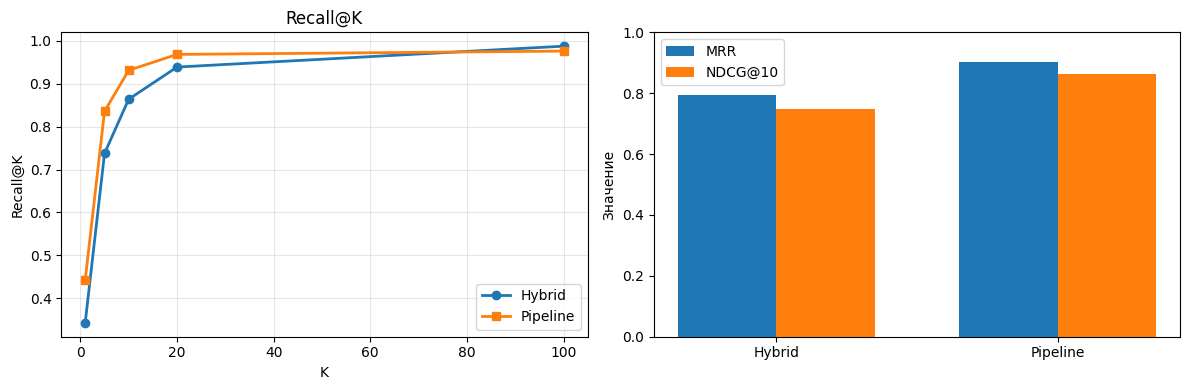

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ks = [1, 5, 10, 20, 100]
hybrid_recalls = [hybrid_metrics[f'Recall@{k}'] for k in ks]
pipeline_recalls = [pipeline_metrics[f'Recall@{k}'] for k in ks]

axes[0].plot(ks, hybrid_recalls, 'o-', label='Hybrid', linewidth=2)
axes[0].plot(ks, pipeline_recalls, 's-', label='Pipeline', linewidth=2)
axes[0].set_xlabel('K')
axes[0].set_ylabel('Recall@K')
axes[0].set_title('Recall@K')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

methods = ['Hybrid', 'Pipeline']
mrr = [hybrid_metrics['MRR'], pipeline_metrics['MRR']]
ndcg = [hybrid_metrics['NDCG@10'], pipeline_metrics['NDCG@10']]

x = np.arange(len(methods))
width = 0.35
axes[1].bar(x - width/2, mrr, width, label='MRR')
axes[1].bar(x + width/2, ndcg, width, label='NDCG@10')
axes[1].set_ylabel('Значение')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('hybrid_pipeline_results.png', dpi=150)
plt.show()

## 10. Сохранение результатов

In [25]:
results = {
    'best_alpha': BEST_ALPHA,
    'hybrid_metrics': hybrid_metrics,
    'pipeline_metrics': pipeline_metrics
}

with open('hybrid_pipeline_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("Результаты сохранены: hybrid_pipeline_results.json")

Результаты сохранены: hybrid_pipeline_results.json


In [26]:
print(f"""
Итоги Hybrid + Reranker:

Конфигурация:
  BM25: BPE токенизация
  Dense: multilingual-e5-base
  Hybrid alpha: {BEST_ALPHA}
  Reranker: BAAI/bge-reranker-v2-m3

Результаты (dev):
  Hybrid:
    MRR:       {hybrid_metrics['MRR']:.4f}
    Recall@10: {hybrid_metrics['Recall@10']:.4f}
    
  Pipeline:
    MRR:       {pipeline_metrics['MRR']:.4f}
    Recall@10: {pipeline_metrics['Recall@10']:.4f}
""")


Итоги Hybrid + Reranker:

Конфигурация:
  BM25: BPE токенизация
  Dense: multilingual-e5-base
  Hybrid alpha: 1.0
  Reranker: BAAI/bge-reranker-v2-m3

Результаты (dev):
  Hybrid:
    MRR:       0.7935
    Recall@10: 0.8641
    
  Pipeline:
    MRR:       0.9019
    Recall@10: 0.9315

